11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training with activation: sigmoid
Epoch 1/8 | train_loss=2.2726 train_acc=33.70% | test_loss=2.2200 test_acc=34.39%
Epoch 2/8 | train_loss=2.0220 train_acc=53.80% | test_loss=1.6641 test_acc=52.89%
Epoch 3/8 | train_loss=1.3186 train_acc=72.15% | test_loss=1.0217 test_acc=72.75%
Epoch 4/8 | train_loss=0.8735 train_acc=79.95% | test_loss=0.7373 test_acc=80.11%
Epoch 5/8 | train_loss=0.6664 train_acc=84.15% | test_loss=0.5847 test_acc=84.04%
Epoch 6/8 | train_loss=0.5523 train_acc=86.75% | test_loss=0.5000 test_acc=86.28%
Epoch 7/8 | train_loss=0.4847 train_acc=87.65% | test_loss=0.4467 test_acc=87.65%
Epoch 8/8 | train_loss=0.4416 train_acc=88.25% | test_loss=0.4111 test_acc=88.42%

Training with activation: tanh
Epoch 1/8 | train_loss=0.6967 train_acc=89.65% | test_loss=0.3570 test_acc=90.10%
Epoch 2/8 | train_loss=0.3307 train_acc=91.20% | test_loss=0.2916 test_acc=91.64%
Epoch 3/8 | train_loss=0.2831 train_acc=92.40% | test_loss=0.2

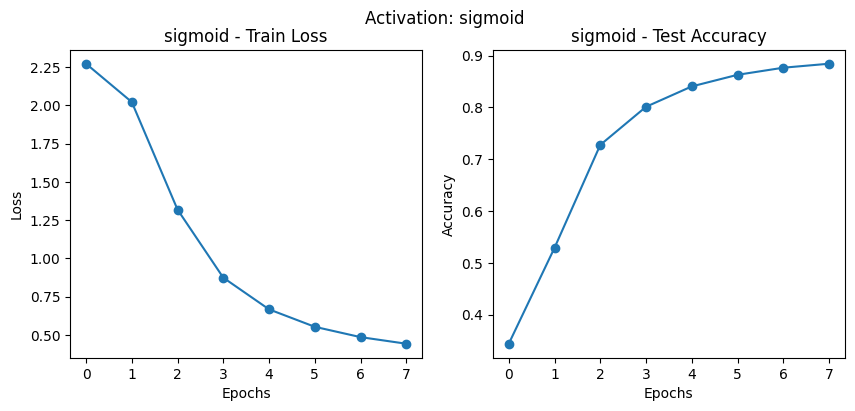

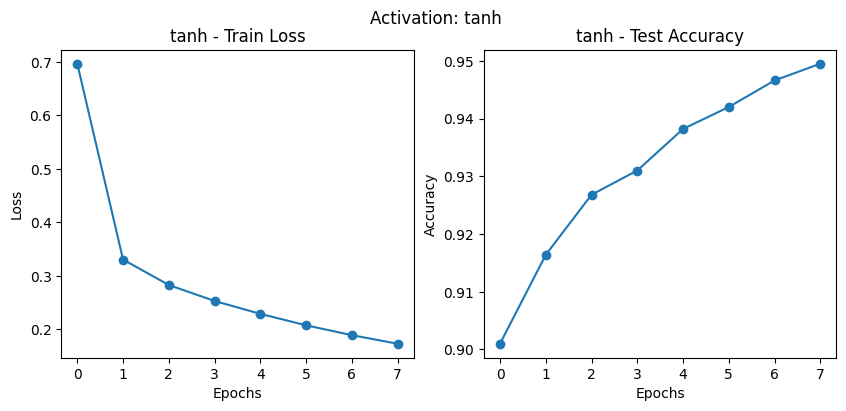

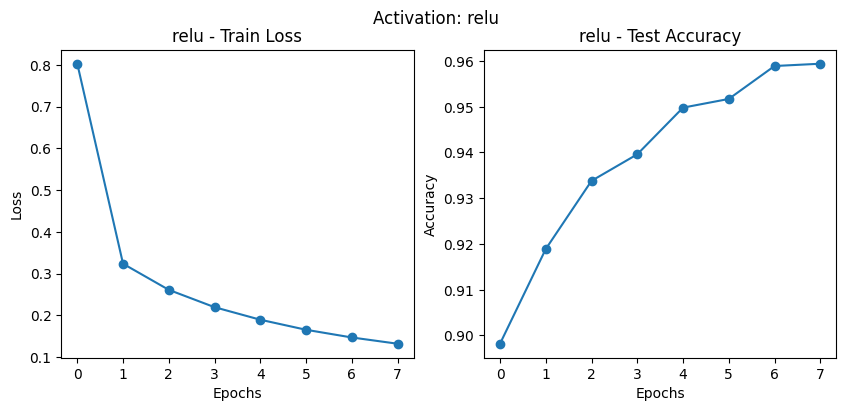

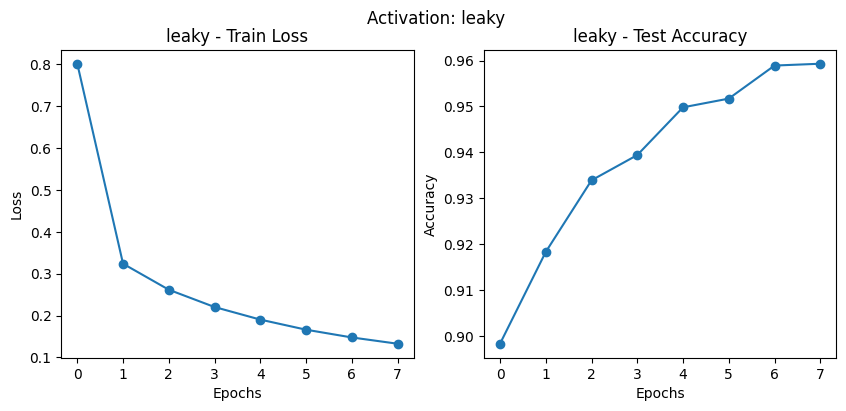

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tqdm import trange


def sigmoid(x): return 1.0 / (1.0 + np.exp(-x))
def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def tanh(x): return np.tanh(x)
def dtanh(x):
    return 1.0 - np.tanh(x)**2

def relu(x): return np.maximum(0, x)
def drelu(x): return (x > 0).astype(float)

def leaky_relu(x, a=0.01):
    return np.where(x > 0, x, a * x)
def dleaky_relu(x, a=0.01):
    dx = np.ones_like(x)
    dx[x <= 0] = a
    return dx


def softmax(z):
    z = z - np.max(z, axis=1, keepdims=True)
    expz = np.exp(z)
    return expz / np.sum(expz, axis=1, keepdims=True)

def cross_entropy_loss(probs, y_true_onehot):

    m = y_true_onehot.shape[0]
    p = np.clip(probs, 1e-12, 1.0)
    return -np.sum(y_true_onehot * np.log(p)) / m

class MLP:
    def __init__(self, input_dim, hidden_dims, output_dim, activation='relu', lr=0.1, weight_scale=0.01, seed=42):
        np.random.seed(seed)
        self.layers = [input_dim] + hidden_dims + [output_dim]
        self.L = len(self.layers) - 1
        self.lr = lr

        self.W = [None] * self.L
        self.b = [None] * self.L
        for i in range(self.L):
            self.W[i] = np.random.randn(self.layers[i], self.layers[i+1]) * weight_scale
            self.b[i] = np.zeros((1, self.layers[i+1]))

        if activation == 'sigmoid':
            self.act = sigmoid; self.dact = dsigmoid
        elif activation == 'tanh':
            self.act = tanh; self.dact = dtanh
        elif activation == 'relu':
            self.act = relu; self.dact = drelu
        elif activation == 'leaky':
            self.act = lambda x: leaky_relu(x, a=0.01)
            self.dact = lambda x: dleaky_relu(x, a=0.01)
        else:
            raise ValueError("activation must be: sigmoid, tanh, relu, leaky")

    def forward(self, X):
        """Forward pass. Stores pre-activations (Z) and activations (A)."""
        A = X
        self.As = [A]
        self.Zs = []
        for i in range(self.L - 1):
            Z = A.dot(self.W[i]) + self.b[i]
            A = self.act(Z)
            self.Zs.append(Z)
            self.As.append(A)

        Z = A.dot(self.W[-1]) + self.b[-1]
        self.Zs.append(Z)
        self.As.append(Z)
        probs = softmax(Z)
        return probs

    def backward(self, probs, y_onehot):
        """Backpropagation. Compute gradients for all W and b."""
        m = y_onehot.shape[0]
        grads_W = [None] * self.L
        grads_b = [None] * self.L


        dZ = (probs - y_onehot) / m
        grads_W[-1] = self.As[-2].T.dot(dZ)
        grads_b[-1] = np.sum(dZ, axis=0, keepdims=True)


        dA_prev = dZ.dot(self.W[-1].T)
        for l in range(self.L - 2, -1, -1):
            Z = self.Zs[l]
            dZ = dA_prev * self.dact(Z)
            grads_W[l] = self.As[l].T.dot(dZ)
            grads_b[l] = np.sum(dZ, axis=0, keepdims=True)
            if l > 0:
                dA_prev = dZ.dot(self.W[l].T)

        return grads_W, grads_b

    def step(self, grads_W, grads_b):
        """SGD parameter update (vanilla)."""
        for i in range(self.L):
            self.W[i] -= self.lr * grads_W[i]
            self.b[i] -= self.lr * grads_b[i]

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test  = x_test.astype(np.float32) / 255.0
x_train = x_train.reshape(-1, 28*28)
x_test  = x_test.reshape(-1, 28*28)



y_train_oh = to_categorical(y_train, 10)
y_test_oh  = to_categorical(y_test, 10)


def train_experiment(activation='relu',
                     hidden_dims=[128, 64],
                     lr=0.1,
                     epochs=10,
                     batch_size=128,
                     weight_scale=0.05,
                     seed=123):
    model = MLP(input_dim=28*28, hidden_dims=hidden_dims, output_dim=10,
                activation=activation, lr=lr, weight_scale=weight_scale, seed=seed)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    n = x_train.shape[0]
    steps_per_epoch = n // batch_size

    for epoch in range(epochs):

        perm = np.random.permutation(n)
        x_shuf = x_train[perm]
        y_shuf = y_train_oh[perm]
        epoch_loss = 0.0

        for i in range(steps_per_epoch):
            start = i * batch_size
            end = start + batch_size
            Xb = x_shuf[start:end]
            yb = y_shuf[start:end]


            probs = model.forward(Xb)
            loss = cross_entropy_loss(probs, yb)
            epoch_loss += loss

            grads_W, grads_b = model.backward(probs, yb)


            model.step(grads_W, grads_b)


        avg_loss = epoch_loss / steps_per_epoch
        y_pred_train = model.predict(x_train[:2000])
        train_acc = (y_pred_train == y_train[:2000]).mean()

        probs_test = model.forward(x_test)
        test_loss = cross_entropy_loss(probs_test, y_test_oh)
        test_pred = np.argmax(probs_test, axis=1)
        test_acc = (test_pred == y_test).mean()

        history['train_loss'].append(avg_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{epochs} | train_loss={avg_loss:.4f} train_acc={train_acc*100:.2f}% | test_loss={test_loss:.4f} test_acc={test_acc*100:.2f}%")

    return model, history


activations = ['sigmoid', 'tanh', 'relu', 'leaky']
results = {}


for act in activations:
    print("\n" + "="*50)
    print(f"Training with activation: {act}")
    model, hist = train_experiment(activation=act, hidden_dims=[256, 128], lr=0.1, epochs=8, batch_size=256, weight_scale=0.05, seed=42)
    results[act] = hist


for act, hist in results.items():
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(hist['train_loss'], marker='o')
    plt.title(f"{act} - Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(hist['test_acc'], marker='o')
    plt.title(f"{act} - Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")

    plt.suptitle(f"Activation: {act}")
    plt.show()
